In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

In [2]:
n_timesteps_in = 24 
n_timesteps_out = 28
n_features_in = 1
n_features_out = 1

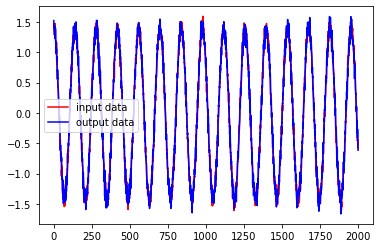

In [13]:
time_series_length = 2000
t = np.linspace(0, 15, time_series_length)
ts_input = np.cos(t) / 10 + 8 * np.cos(t*6) + 0.4 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 9 + 7 * np.cos(t*6) + 0.4 * np.random.standard_normal(size=time_series_length)

ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()

In [14]:
train_size = int(len(ts_input) * 0.75)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

In [15]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)

    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)

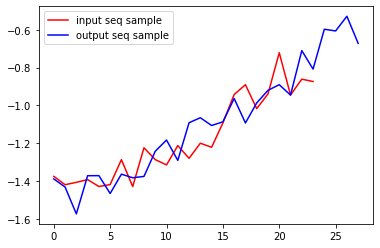

In [16]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()
plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()

In [17]:
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [18]:
n_units = 256

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [19]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 28, 1)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        264192      ['input_3[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [21]:
model.compile(optimizer='adam', loss='mse')
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=25, batch_size=64, validation_split=0.3, callbacks = my_callbacks, verbose=2)

Epoch 1/25
6/6 - 11s - loss: 0.5606 - val_loss: 0.2890 - 11s/epoch - 2s/step
Epoch 2/25
6/6 - 2s - loss: 0.2373 - val_loss: 0.1902 - 2s/epoch - 258ms/step
Epoch 3/25
6/6 - 1s - loss: 0.1473 - val_loss: 0.1326 - 1s/epoch - 243ms/step
Epoch 4/25
6/6 - 1s - loss: 0.1166 - val_loss: 0.0929 - 1s/epoch - 238ms/step
Epoch 5/25
6/6 - 1s - loss: 0.0939 - val_loss: 0.0894 - 1s/epoch - 245ms/step
Epoch 6/25
6/6 - 2s - loss: 0.0765 - val_loss: 0.0664 - 2s/epoch - 295ms/step
Epoch 7/25
6/6 - 2s - loss: 0.0606 - val_loss: 0.0550 - 2s/epoch - 289ms/step
Epoch 8/25
6/6 - 2s - loss: 0.0461 - val_loss: 0.0361 - 2s/epoch - 310ms/step
Epoch 9/25
6/6 - 1s - loss: 0.0299 - val_loss: 0.0275 - 999ms/epoch - 166ms/step
Epoch 10/25
6/6 - 1s - loss: 0.0244 - val_loss: 0.0220 - 1s/epoch - 182ms/step
Epoch 11/25
6/6 - 1s - loss: 0.0192 - val_loss: 0.0188 - 964ms/epoch - 161ms/step
Epoch 12/25
6/6 - 1s - loss: 0.0160 - val_loss: 0.0138 - 1s/epoch - 184ms/step
Epoch 13/25
6/6 - 1s - loss: 0.0136 - val_loss: 0.0125 -

In [22]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

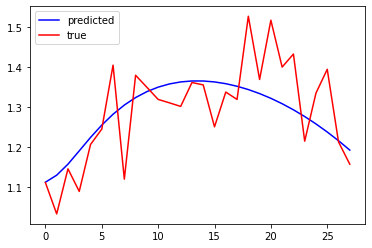

In [23]:
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()